## CS4243 Assignment 2


In [71]:
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
import cv2


## Part 1: Keypoint Matching & Homography
### Question 1

In [72]:
# Read left and right images
left_img = cv2.cvtColor(cv2.imread("data\\building_left.jpg"), cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(cv2.imread("data\\building_right.jpg"), cv2.COLOR_BGR2RGB)
# plt.imshow(left_img)
left_img.shape

(683, 1024, 3)

In [73]:
# Set 1 keypoints
pts1 = np.array([[936, 652], [718, 646], [870, 349], [889, 634]])
pts2 = np.array([[464, 616], [254, 611], [424, 325], [422, 599]])

# Compute homography
H1, _ = cv2.findHomography(pts2, pts1)

# Set 2 keypoints
pts1 = np.array([[936, 652], [718, 646], [889, 634], [894, 623]])
pts2 = np.array([[464, 616], [254, 611], [422, 599], [430, 588]])

# Compute homography
H2, _ = cv2.findHomography(pts2, pts1)

print(H1)
print(H2)

[[ 7.13842070e-01  5.06927165e-02  4.49933241e+02]
 [-1.64096291e-01  9.07008199e-01  8.33141247e+01]
 [-2.58508030e-04 -1.96786785e-05  1.00000000e+00]]
[[ 5.78113458e-01 -6.35718591e-01  5.94628898e+02]
 [ 5.11399566e-02 -2.07400386e-02  3.17325365e+02]
 [ 7.66973065e-05 -8.63787353e-04  1.00000000e+00]]


True

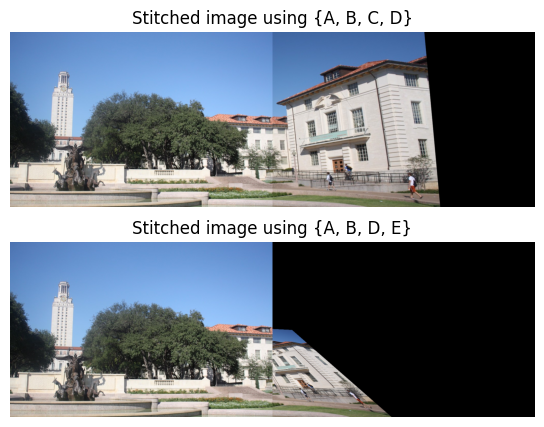

In [74]:
# Warp right image using H1
stitched1 = cv2.warpPerspective(right_img, H1, (left_img.shape[1]+right_img.shape[1], right_img.shape[0]))
stitched1[0:left_img.shape[0], 0:left_img.shape[1]] = left_img

stitched2 = cv2.warpPerspective(right_img, H2, (left_img.shape[1]+right_img.shape[1], right_img.shape[0]))
stitched2[0:left_img.shape[0], 0:left_img.shape[1]] = left_img


fig, axes = plt.subplots(2, 1, figsize=(15,5))

axes[0].imshow(stitched1)
axes[0].set_title('Stitched image using {A, B, C, D}')
axes[0].axis('off')

axes[1].imshow(stitched2)
axes[1].set_title('Stitched image using {A, B, D, E}')
axes[1].axis('off')

cv2.imwrite('stitched1.jpg', cv2.cvtColor(stitched1, cv2.COLOR_BGR2RGB))
cv2.imwrite('stitched2.jpg', cv2.cvtColor(stitched2, cv2.COLOR_BGR2RGB))

### Explain why the stitching from Set 2 fails:
A, B, D and E are very close to each other on the Y axis. Therefore, noise greatly affects the homography computed suing these keypoints, and cause significant vertical distortions.

### Question 2

5239 2519 5594


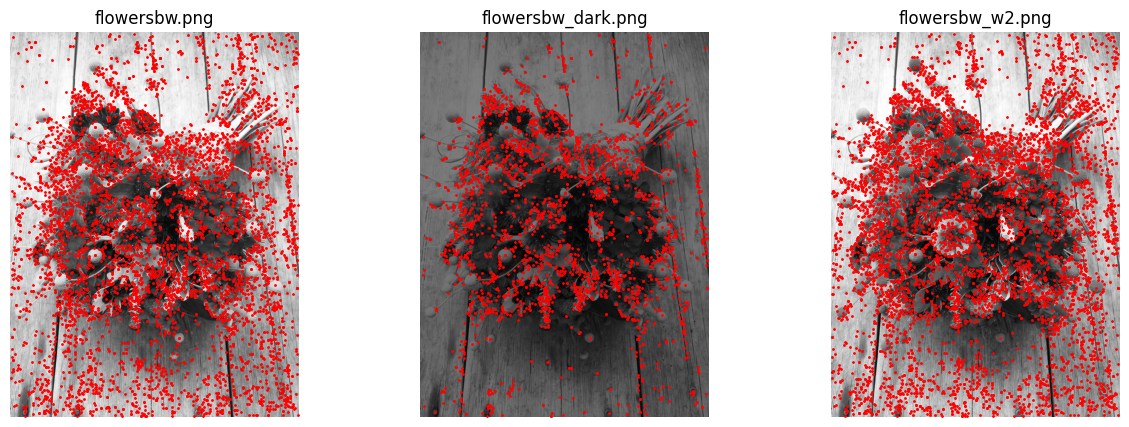

In [75]:
# Load the images
img_a = cv2.imread('data\\flowers.png')
img_b = cv2.imread('data\\flowersbw.png')
img_c = cv2.imread('data\\flowersbw_dark.png')
img_d = cv2.imread('data\\flowersbw_w2.png')

# Create SIFT detector and compute keypoints and descriptors
sift = cv2.SIFT_create()
kp_a, des_a = sift.detectAndCompute(img_a, None)
kp_b, des_b = sift.detectAndCompute(img_b, None)
kp_c, des_c = sift.detectAndCompute(img_c, None)
kp_d, des_d = sift.detectAndCompute(img_d, None)

# Visualize the keypoints as a scatterplot
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
axes[0].scatter([kp.pt[0] for kp in kp_b], [kp.pt[1] for kp in kp_b], s=1, color='red')
axes[0].set_title('flowersbw.png')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
axes[1].scatter([kp.pt[0] for kp in kp_c], [kp.pt[1] for kp in kp_c], s=1, color='red')
axes[1].set_title('flowersbw_dark.png')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(img_d, cv2.COLOR_BGR2RGB))
axes[2].scatter([kp.pt[0] for kp in kp_d], [kp.pt[1] for kp in kp_d], s=1, color='red')
axes[2].set_title('flowersbw_w2.png')
axes[2].axis('off')

print(len(kp_b), len(kp_c), len(kp_d))

plt.show()


### Using the results of (b) as a reference, compare and comment on the number of keypoints and their locations for image (c) and (d).  Explain any differences that arise.
(c) has less keypoints detected than (b), while (d) has roughly the same number of keypoints detected as (b). The keypoints also appear in different locations. When the intensity is reduced like in (c), the keypoints change their location because the contrast in the image is reduced. However, this effect is small and most keypoints stay the same or shift slightly. 

2374 2110


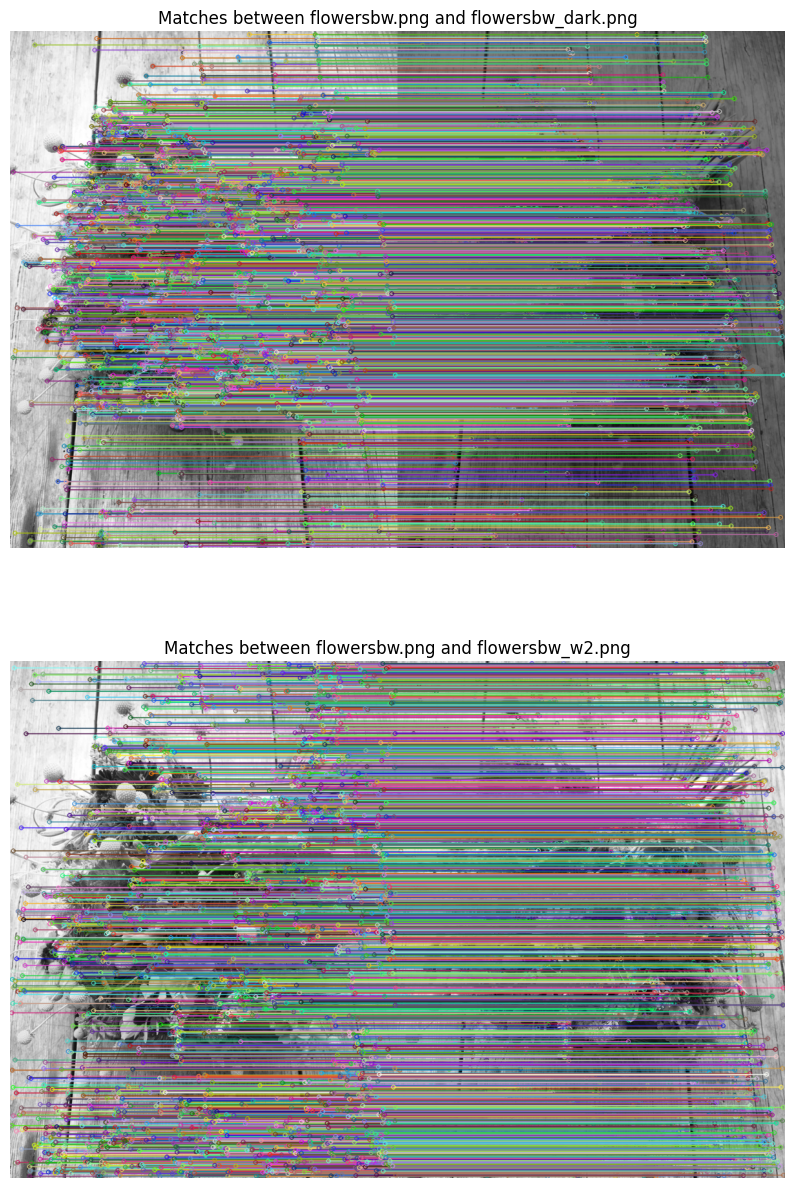

In [76]:
# Create BFMatcher object and perform matching
bf = cv2.BFMatcher()
matches_bc = bf.knnMatch(des_b, des_c, k=2)
matches_bd = bf.knnMatch(des_b, des_d, k=2)

# Apply ratio test
good_matches_bc = []
for m, n in matches_bc:
    if m.distance < 0.5 * n.distance:
        good_matches_bc.append([m])
        
good_matches_bd = []
for m, n in matches_bd:
    if m.distance < 0.5 * n.distance:
        good_matches_bd.append([m])
        
# Draw matched keypoints
img1 = cv2.drawMatchesKnn(img_b, kp_b, img_c, kp_c, good_matches_bc, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img2 = cv2.drawMatchesKnn(img_b, kp_b, img_d, kp_d, good_matches_bd, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(len(good_matches_bc), len(good_matches_bd))

# Show the images
fig, axes = plt.subplots(2, 1, figsize=(10,15))

axes[0].imshow(img1)
axes[0].set_title('Matches between flowersbw.png and flowersbw_dark.png')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Matches between flowersbw.png and flowersbw_w2.png')
axes[1].axis('off')

plt.show()

# Compare and comment on the number of matched keypoints and their locations for the two image pairs. Explain any differences that arise.
The matchings have roughly the same number of keypoint matches. However, the matchings between flowersbw.png and flowersbw_dark.png has less keypoints on the background of the image compared to the matchings between flowersbw.png and flowersbw_w2.png.
The SIFT feature detector looks for local features such as gradient intensity and direction in an image. flowersbw_dark.png has low brightness and contrast, so these features may be harder to detect in the background of the image, where there is lower variation in intensity.

# Question 4

In [77]:
import csv

# Load the first frame
frame = cv2.imread('data/Crowd_PETS09/frame_0000.jpg')

# Extract the pedestrian bounding boxes
objects = []
with open('data/gt.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        if int(row[0]) == 1:
            object = {'id': int(row[1]), 'bbox': (int(row[2]), int(row[3]), float(row[4]), float(row[5]))}
            objects.append(object)
        else:
            break

# Initialize the BOOSTING trackers
trackers1 = {}
for object in objects:
    tracker1 = cv2.legacy.TrackerBoosting_create()
    bbox = object['bbox']
    tracker1.init(frame, [int(x) for x in bbox])
    trackers1[object['id']] = tracker1

# Track the pedestrians in each frame and save the results to a CSV file
with open('data/tracker1.csv', 'w+', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(231):
        frame = cv2.imread(f'data/Crowd_PETS09/frame_{i:04d}.jpg')
        for id, tracker1 in trackers1.items():
            success, bbox = tracker1.update(frame)
            if success:
                x, y, w, h = bbox
                cx = x + w / 2
                cy = y + h / 2
                writer.writerow([i + 1, id, x, y, w, h, -1, -1, -1, -1])
            else:
                writer.writerow([i + 1, id, -1, -1, -1, -1, -1, -1, -1, -1])

# Initialize the MIL trackers
trackers2 = {}
for object in objects:
    tracker1 = cv2.TrackerMIL_create() 
    bbox = object['bbox']
    tracker1.init(frame, [int(x) for x in bbox])
    trackers2[object['id']] = tracker1

# Track the pedestrians in each frame and save the results to a CSV file
with open('data/tracker1.csv', 'w+', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(231):
        frame = cv2.imread(f'data/Crowd_PETS09/frame_{i:04d}.jpg')
        for id, tracker1 in trackers2.items():
            success, bbox = tracker1.update(frame)
            if success:
                x, y, w, h = bbox
                cx = x + w / 2
                cy = y + h / 2
                writer.writerow([i + 1, id, x, y, w, h, -1, -1, -1, -1])
            else:
                writer.writerow([i + 1, id, -1, -1, -1, -1, -1, -1, -1, -1])


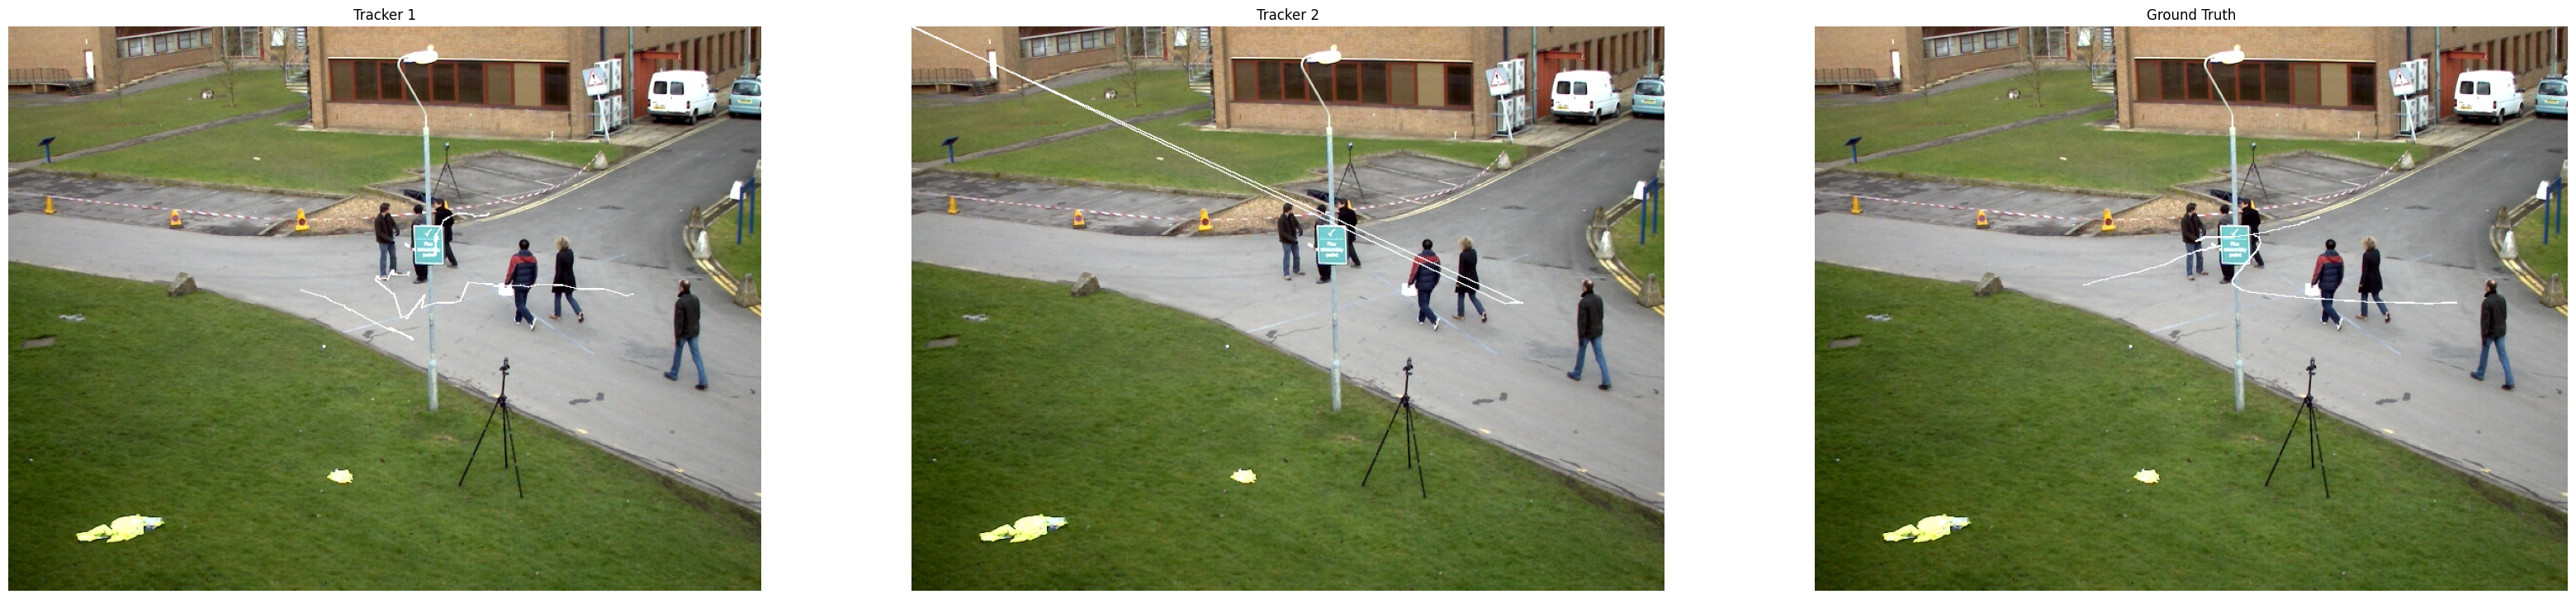

In [78]:
# code from visualization.py
from PIL import Image, ImageDraw

def draw_visualization(path):
    frame_50 = Image.open('data/frame_0050.jpg')
    labels = {}
    with open(path) as csvfile:
        rows = csv.reader(csvfile, delimiter=',')
        for row in rows:
            if int(row[0]) <= 50 and row[1] in ['9', '15', '19']:
                if row[1] not in list(labels):
                    labels[row[1]] = []
                labels[row[1]].append({'frame': int(row[0]), 'bb_left': float(row[2]), 'bb_top': float(row[3]), 'bb_width': float(row[4]), 'bb_height': float(row[5])})


    draw = ImageDraw.Draw(frame_50)
    for id in labels:
        points = []
        for bbox in labels[id]:
            cx = bbox['bb_left'] + bbox['bb_width']/2
            cy = bbox['bb_top'] + bbox['bb_height']/2
            points.append((int(cx), int(cy)))
        draw.line(points, width=2, fill='white')
    
    name = path.split('/')[-1].split('.')[0]
    frame_50.save('data/'+name+'.png')

draw_visualization('data/tracker1.csv')
draw_visualization('data/tracker2.csv')
draw_visualization('data/gt.csv')

# Show the images
fig, axes = plt.subplots(1, 3, figsize=(40,10))

axes[0].imshow(Image.open('data/tracker1.png'))
axes[0].set_title('Tracker 1')
axes[0].axis('off')

axes[1].imshow(Image.open('data/tracker2.png'))
axes[1].set_title('Tracker 2')
axes[1].axis('off')

axes[2].imshow(Image.open('data/gt.png'))
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.show()

## Comment on qualitative differences between the tracks.
The BOOSTING tracker is more accurat, but much jerkier compared to the ground truth. The MIL tracker is completely off.

In [79]:
def calculate_iou(box1, box2):
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(yi2 - yi1, 0) * max(xi2 - xi1, 0)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = (box1_area + box2_area) - inter_area

    # compute the IoU
    iou = inter_area / union_area

    return iou


# Load ground truth
gt = {}
with open('data/gt.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        if row[1] in ['9', '15', '19']:
            if row[1] not in gt:
                gt[row[1]] = {}
            gt[row[1]][int(row[0])] = [float(row[2]), float(row[3]), float(row[4]), float(row[5])]

# Load tracker output
tracker1 = {}
with open('data/tracker1.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        frame = int(row[0])
        if frame not in tracker1:
            tracker1[frame] = {}
        tracker1[frame][int(row[1])] = [float(row[2]), float(row[3]), float(row[4]), float(row[5])]

tracker2 = {}
with open('data/tracker2.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        frame = int(row[0])
        if frame not in tracker2:
            tracker2[frame] = {}
        tracker2[frame][int(row[1])] = [float(row[2]), float(row[3]), float(row[4]), float(row[5])]

# Calculate MOPT and MOTA for tracker 1
iou_threshold = 0.5
tp = 0
fp = 0
fn = 0
id_switches = 0

for frame in tracker1:
    for id in tracker1[frame]:
        predicted_bbox = tracker1[frame][id]
        if id in gt and frame in gt[id]:
            gt_bbox = gt[id][frame]
            iou = calculate_iou(predicted_bbox, gt_bbox)
            if iou >= iou_threshold:
                tp += 1
                del gt[id][frame]
            else:
                fp += 1
        else:
            fp += 1

    for id in gt:
        if frame in gt[id]:
            fn += 1

    for id in gt:
        last_frame = max(gt[id])
        if last_frame < frame and id in tracker1[last_frame]:
            id_switches += 1

mopt = tp / (tp + fp + id_switches)
mota = 1 - (fn + fp + id_switches) / (tp + fn)

print("BOOSTING tracker:")
print("MOPT: %.2f" % mopt)
print("MOTA: %.2f" % mota)

# Calculate MOPT and MOTA for tracker 2
iou_threshold = 0.5
tp = 0
fp = 0
fn = 0
id_switches = 0
for frame in tracker2:
    for id in tracker2[frame]:
        predicted_bbox = tracker1[frame][id]
        if id in gt and frame in gt[id]:
            gt_bbox = gt[id][frame]
            iou = calculate_iou(predicted_bbox, gt_bbox)
            if iou >= iou_threshold:
                tp += 1
                del gt[id][frame]
            else:
                fp += 1
        else:
            fp += 1

    for id in gt:
        if frame in gt[id]:
            fn += 1

    for id in gt:
        last_frame = max(gt[id])
        if last_frame < frame and id in tracker2[last_frame]:
            id_switches += 1

# Calculate MOPT and MOTA for tracker 2
mopt = tp / (tp + fp + id_switches)
mota = 1 - (fn + fp + id_switches) / (tp + fn)


print("MIL tracker:")
print("MOPT: %.2f" % mopt)
print("MOTA: %.2f" % mota)


BOOSTING tracker:
MOPT: 0.00
MOTA: -1.19
MIL tracker:
MOPT: 0.00
MOTA: -1.19


# For each tracker, identify a failure case and analyse the potential cause(s) of the failure.
The trackers fail when the object is occluded by another object. This is because the tracker relies on the object being tracked to be visible in the image. When the object is occluded, the tracker cannot find the object in the image and cannot update the position of the object. If the occluding object is also moving, then the tracker often shifts to the tracking the occluding object instead.  

# Question 5: Propose a method to prevent ID shift.  State the assumptions, describe the algorithm steps, and discuss possible drawbacks.
In addition to motion-based methods, we can use appearance-based features to differentiate the objects. These features can include color histograms or texture features. The assumptions are that each person has a unique appearance that can be used to distinguish them from others, and that the appearance of the object do not change (by much). The algorithm steps are as follows:

1. Detect and track objects using a motion-based approach, such as a KCF tracker.
1. Extract features from the detected objects in the box.
1. When a tracked object moves from one frame to the next, for each box, calculate obtain a score based match it to the closest appearance model using a distance metric, such as Euclidean distance. If the distance between the tracked object and the appearance model is below a certain threshold, associate them with the same ID. Otherwise, assign a new ID.
1. Update the appearance model for each object based on the features measured in this frame.

Possible drawbacks of this approach include:

Computational complexity: The appearance-based methods can be computationally expensive, especially when dealing with large datasets.

Occlusions: Appearance-based methods may not work well when objects are occluded or partially hidden from view. When they come back into view, they will be assigned as a different object

Changes in appearance: Appearance-based methods may not work well when there are significant changes in appearance, such as changes in pose, lighting, rotation, etc.

# Question 6

Assume each step to be every time the box moves up and down alternatingly.

In [80]:
with open('data/tracker1.csv', newline='') as csvfile:
    gt_reader = csv.reader(csvfile)
    prev_bb_top = None
    step_count = 0
    ascending = True
    for row in gt_reader:
        frame_num, obj_id, left, top = map(float, row[0:4])
        if frame_num <= 150:
            if obj_id == 19:
                if prev_bb_top is not None:
                    if top < prev_bb_top and ascending:
                        step_count += 1
                        ascending = False
                    elif top > prev_bb_top and not ascending:
                        step_count += 1
                        ascending = True
                prev_bb_top = top
        else:
            break
    print(f"Number of steps taken by individual with ID=19: {step_count}")

Number of steps taken by individual with ID=19: 60


# Question 7

In [81]:
import csv
import numpy as np

# Read the ground truth file
with open('data/gt.csv') as csvfile:
    gt_reader = csv.reader(csvfile)
    gt_data = [row for row in gt_reader]

# Get the ground truth data for the individual with id=16 between frames 117 and 221
id_9_gt = [list(map(float, row[2:7])) for row in gt_data if int(row[1]) == 16 and int(row[0]) >= 117 and int(row[0]) <= 221]

# Define the homography matrix
H = np.array([[7.358, 21.55, -5886], [-1.861, 22.33, -2400], [0.0012, 0.0207, 1]])

# Project the data onto the virtual ground plane
ground_truth_points = []
for bbox in id_9_gt:
    x = bbox[0] + bbox[2] / 2.0
    y = bbox[1] + bbox[3] / 2.0
    p = np.array([x, y, 1])
    ground_truth_points.append(np.matmul(H, p))

# Calculate the physical distance between consecutive ground truth points
total_distance = 0
for i in range(len(ground_truth_points)-1):
    x1, y1, w1 = ground_truth_points[i]
    x2, y2, w2 = ground_truth_points[i+1]
    total_distance += (np.sqrt((x2/w2 - x1/w1)**2 + (y2/w2 - y1/w1)**2))

# Convert distance to m
total_distance_cm = total_distance / 10

print(f'The physical distance walked by individual with id=9 between frames 117 to 221 is {total_distance_cm:.2f} m.')


The physical distance walked by individual with id=9 between frames 117 to 221 is 116.99 m.
